# Classification Main-Pied - REGION INTERET

## Apprentissage sur stimulation; Test sur imagination

Classification sur voxels 
Masque système moteur obtenus à partir de cartes ICA de NeuroVault (meta analyses) en selectionant mots clés: motor, premotor, sma, foot, hand 
exemple: http://nilearn.github.io/auto_examples/05_advanced/plot_ica_neurovault.html#sphx-glr-auto-examples-05-advanced-plot-ica-neurovault-py

Tous les sujets - Classifieur: GraphNet

### Visualisation des masques

In [6]:
from nilearn.plotting import plot_roi, plot_stat_map
%matplotlib inline

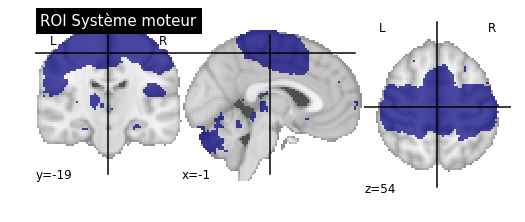

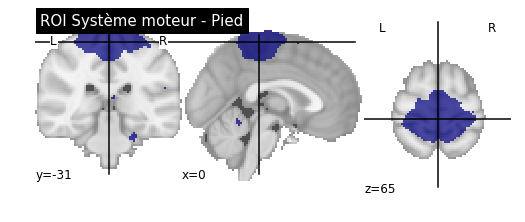

In [6]:
mask='F:/IRM_Marche/ICAMask.nii.gz'
footmask='F:/IRM_Marche/ICAFootMask.nii.gz'

plot_roi(mask, title='ROI Système moteur')
plot_roi(footmask, title='ROI Système moteur - Pied')

In [4]:
from sklearn.pipeline import Pipeline   
from sklearn.svm import SVC
import pandas as pd
from sklearn import preprocessing 
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from sklearn.externals.joblib import Memory
from sklearn.linear_model import LogisticRegression
from nilearn.datasets import load_mni152_brain_mask,load_mni152_template
from nilearn.image import resample_img
from nilearn import plotting, image 
from nibabel.nifti1 import Nifti1Image
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from nilearn.plotting import plot_stat_map, show
import os.path  
import sys 
sys.path[0]='Z:\GitHub\gsp-learn'
from gsplearn.GSPPlot import plot_selectedregions
from sklearn.externals.joblib import Memory


In [5]:
mem = Memory('nilearn_cache')
mask='F:/IRM_Marche/ICAFootMask.nii.gz'
#mask='F:/IRM_Marche/ICAMask.nii.gz'
names={'ap':'ALLAIN',
       'as':'ANDRE',
       'bh':'BEAUGE',
       'bi':'BROCHARD',
       'cmp':'CAPERAN',
       'cas':'CASINTHIE',
       'cs':'CHOIMET',
       'cb':'CHOLOUX',
       'gm':'GAUTIER',
       'gn':'GAUTIERNATH',
       'gbn':'GOURDONBELLARD',
       'mv':'MAROT',
       'ms':'MICHEL',
       'pm':'PAILLEY',
       'pc':'PAPON',
       'ph':'PESNEL',
       'pa':'PETIT',
       'pv':'PIC',
       'pom':'PONTIE',
       'rdc':'RODRIGUEZDIAZ',
       'ti':'TESSON',
       'vs':'VANWATERLOO',
       }
smt='ss'
fold_g = 'F:/IRM_Marche/'
blocks=np.loadtxt(fold_g+'block_main.txt','int')
label=np.loadtxt(fold_g+'label_main.txt','S12')
mask_block=blocks==blocks
for x in range(label.shape[0]):
    if label[x,0]!=label[x-1,0]:
        mask_block[x]=False
    elif label[x,0]!=label[x-2,0]:
        mask_block[x]=False
        
sessions=np.concatenate((np.zeros(150),np.ones(150),2*np.ones(150),3*np.ones(150),4*np.ones(150)) ) 

condition_cat = np.logical_or(label[:,1] == b'foot', label[:,1] == b'hand')
condition_out=np.logical_not(label[:,2]== b'des')
condition_mask= np.logical_and(condition_cat,condition_out)
condition_mask2= np.logical_and(condition_mask,mask_block)

stim_mask=np.logical_and(condition_mask2,(label[:,0]==b'stim'))
imag_mask=np.logical_and(condition_mask2,(label[:,0]==b'imag'))

block=blocks[stim_mask]
y_train=label[stim_mask,1]
y_test=label[imag_mask,1]

In [9]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(
        mask_img=mask, memory_level=1,
        detrend=True,t_r=2.28,high_pass=0.01,sessions=sessions,
        memory=mem)
masker = masker.fit()
    
from nilearn.decoding import SpaceNetClassifier
decoder = SpaceNetClassifier(alphas=1,memory="nilearn_cache", penalty='graph-net',verbose=0)


________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x000000000F3AD6A0>, target_affine=None, copy=False, target_shape=None)
_____________________________________________________resample_img - 0.0s, 0.0min


## Individuel (résultats) - Mask Motor

	Train IMAG	Train Stim
ap	50	44.73684211<br />
as	57.89473684	51.75438596<br />
bh	74.56140351	64.9122807<br />
bi	55.26315789	55.26315789<br />
cas	53.50877193	58.77192982<br />
cb	50	        58.77192982<br />
cmp	71.05263158	78.07017544<br />
cs	86.84210526	64.03508772<br />
gbn	58.77192982	56.14035088<br />
gm	51.75438596	61.40350877<br />
ms	75.43859649	67.54385965<br />
mv	66.66666667	51.75438596<br />
pa	64.9122807	67.54385965<br />
pc	58.77192982	58.77192982<br />
ph	57.89473684	58.77192982<br />
ph	43.85964912	47.36842105<br />
pm	36.84210526	47.36842105<br />
pom	60.52631579	53.50877193<br />
pv	41.22807018	53.50877193<br />
rdc	63.15789474	57.89473684<br />
ti	49.12280702	53.50877193<br />
vs	63.15789474	50

Total	58.69218501	57.33652313

### Plot Mask motor

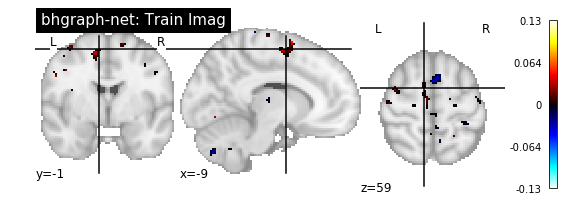

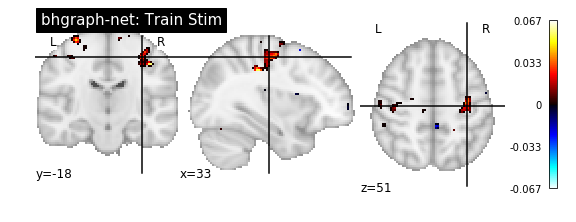

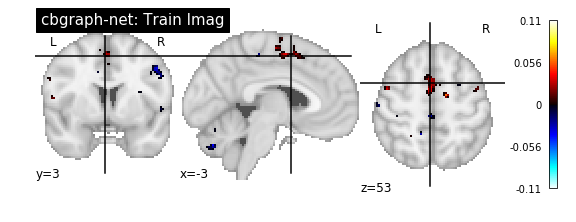

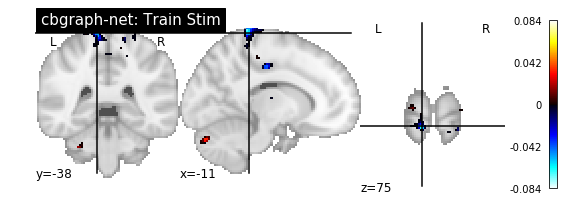

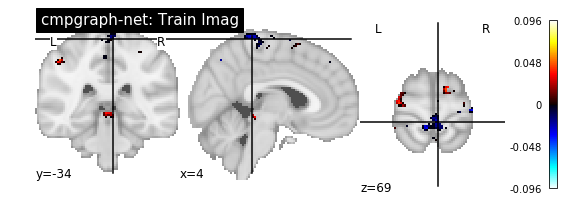

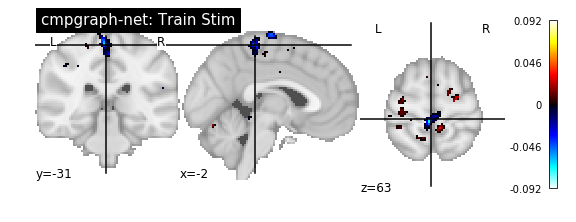

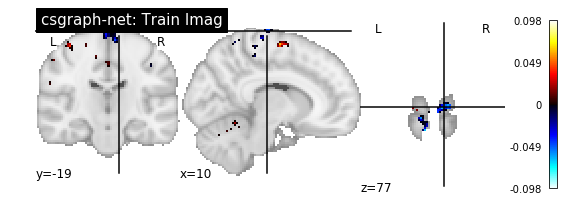

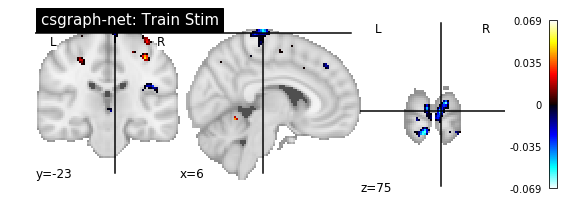

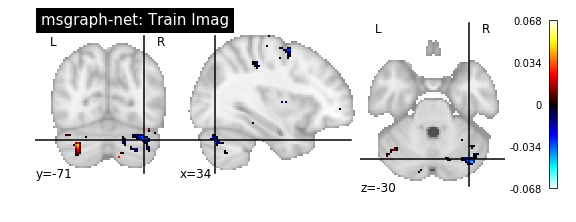

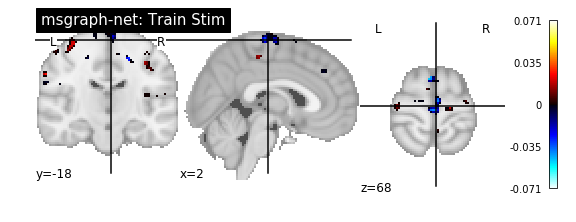

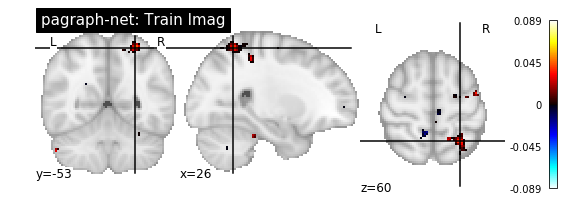

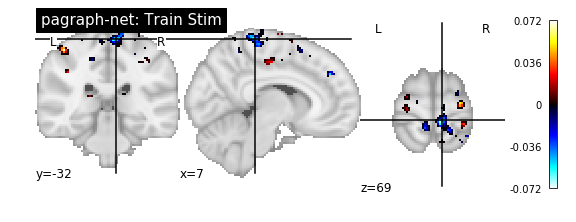

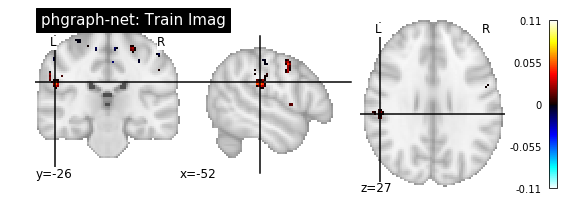

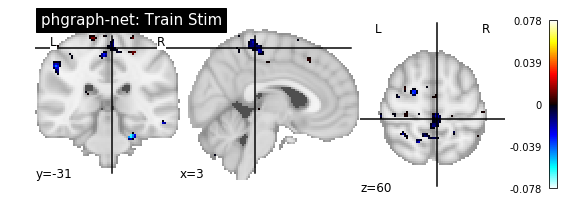

In [7]:
names_sign='ms','cb','cmp','ph','pa','bh','cs'
for n in sorted(names_sign):
    coef_trainimag='D:/marche_result/'+n+'_graph-net_weights_ICAMASK_trainimag.nii'
    plot_stat_map(coef_trainimag, title=n+"graph-net: Train Imag")
    coef_trainstim='D:/marche_result/'+n+'_graph-net_weights_ICAMASK_trainstim.nii'
    plot_stat_map(coef_trainstim, title=n+"graph-net: Train Stim")

## Individuel (résultats) - Mask Foot

	Train IMAG	Train Stim
ap	62.28070175	48.24561404<br />
as	55.26315789	47.36842105<br />
bh	67.54385965	59.64912281<br />
bi	42.98245614	57.01754386<br />
cas	50	51.75438596<br />
cb	74.56140351	62.28070175<br />
cmp	82.45614035	74.56140351<br />
cs	83.33333333	78.94736842<br />
gbn	57.89473684	48.24561404<br />
gm	57.01754386	57.89473684<br />
gn	56.14035088	42.10526316<br />
ms	83.33333333	71.05263158<br />
mv	69.29824561	43.85964912<br />
pa	70.1754386	62.28070175<br />
pc	37.71929825	56.14035088<br />
ph	73.68421053	64.9122807<br />
pm	42.10526316	50.87719298<br />
pom	54.38596491	53.50877193<br />
pv	72.80701754	56.14035088<br />
rdc	57.89473684	54.38596491<br />
ti	61.40350877	53.50877193<br />
vs	59.64912281	52.63157895<br />
		
Total	62.36044657	56.69856459


### Plot coef - Mask Foot (sur certains sujets qui ont de bonnes performances)

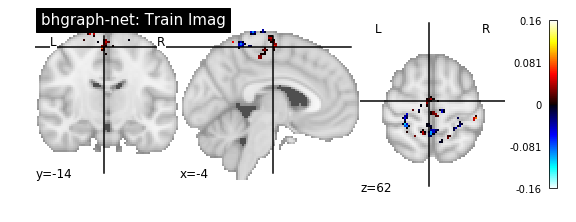

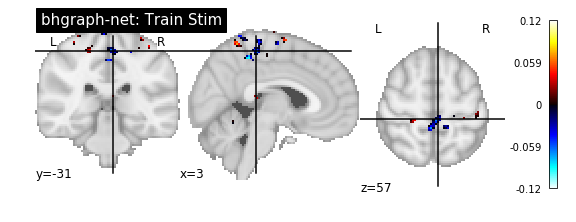

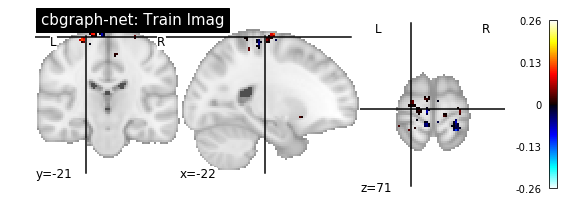

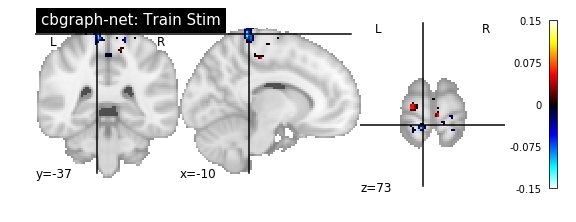

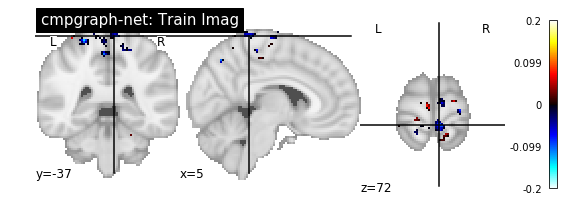

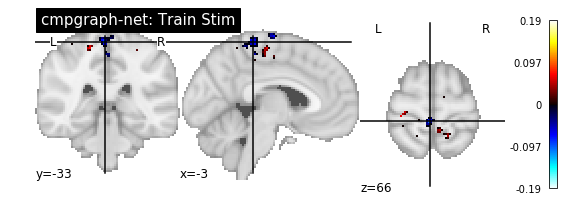

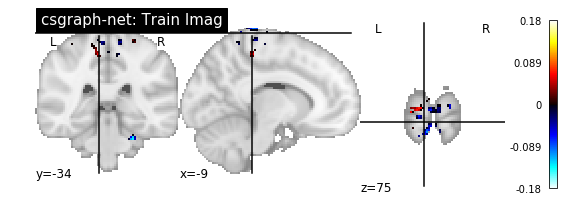

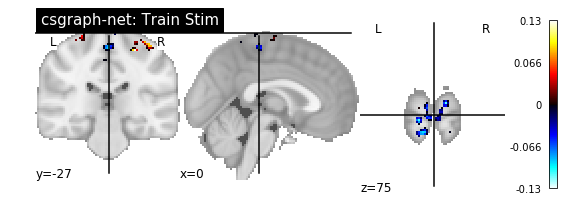

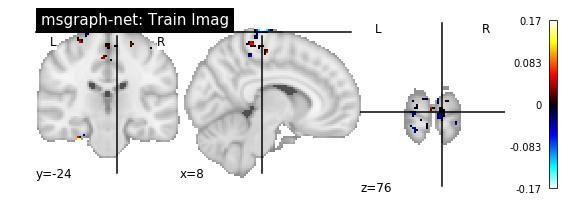

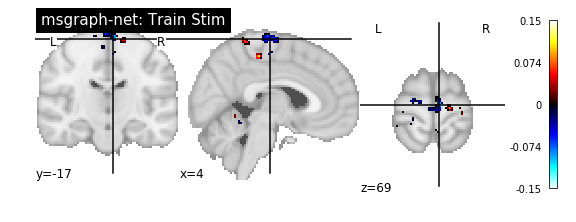

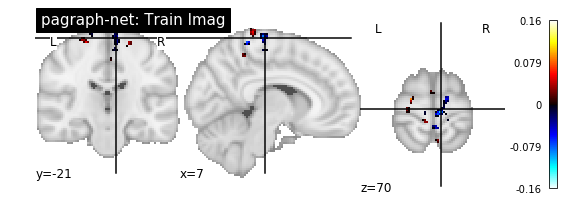

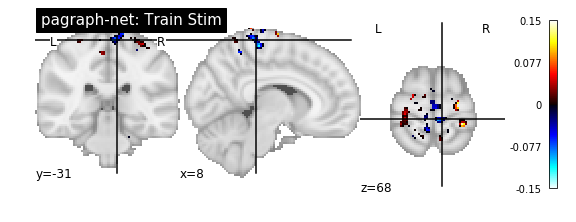

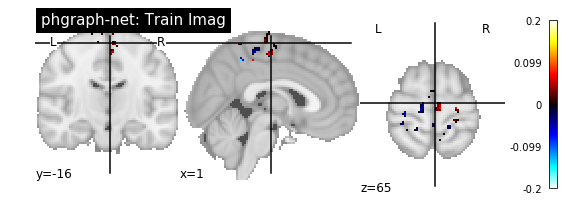

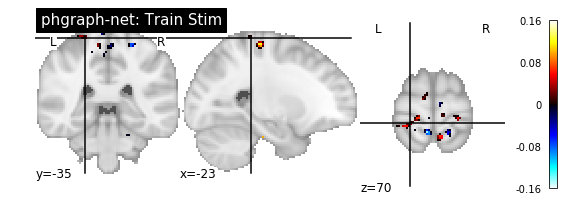

In [13]:
names_sign='ms','cb','cmp','ph','pa','bh','cs'
for n in sorted(names_sign):
    coef_trainimag='D:/marche_result/'+n+'_graph-net_weights_trainimag.nii'
    plot_stat_map(coef_trainimag, title=n+"graph-net: Train Imag")
    coef_trainstim='D:/marche_result/'+n+'_graph-net_weights_trainstim.nii'
    plot_stat_map(coef_trainstim, title=n+"graph-net: Train Stim")

## Train on all subjects (PB MEMOIRE)

In [ ]:
# Get DATA
y_train_all=np.zeros([0,1])
y_test_all=np.zeros([0,1])
block_all=np.zeros([0,1])
from nilearn.image import concat_imgs
for i,(n,foldn) in enumerate(names.items()):
    sim_filename=os.path.join(fold_g,'Temoins_40_60ans',foldn,'Suj','Functional','all_'+smt+'_'+n+'.nii.gz')  
    confounds=os.path.join(fold_g,'Temoins_40_60ans',foldn,'Suj','Functional',n+'_confounds_cond.csv')
    if os.path.exists(sim_filename):
        data=masker.transform(sim_filename, confounds=confounds)
        data_train=data[stim_mask]
        data_test=data[imag_mask]
        y_train_all=np.append(y_train_all,y_train)
        y_test_all=np.append(y_test_all,y_test)
        block_all=np.append(block_all,block)
        img_train=masker.inverse_transform(data_train)
        img_test=masker.inverse_transform(data_test)
        if i>0:
            X_train=concat_imgs((X_train,img_train))
            X_test=concat_imgs((X_test,img_test))
        else:
            X_train=img_train
            X_test=img_test

In [ ]:
decoder.fit(X_train, y_train)
y_pred = decoder.predict(X_test)
accuracy = (y_pred == y_test).mean() * 100.     
coef_img = decoder.coef_img_
coef_img.to_filename(os.path.join('D:/marche_result','all_graph-net_weights_trainimag.nii'))
plot_stat_map(coef_img, title=n+"graph-net: accuracy %g%%" % accuracy,cmap='bwr')